# Abstract

This notebook contains code to reproduce the results in the paper *Classical Music Composition Using State Space Models*.

Note: the types of intervals are:
- Perfect Unision
- minor 2nd
- major 2nd
- minor 3rd
- major 3rd
- perfect 4th
- tritone
- perfect 5th
- minor 6th
- major 6th
- minor 7th
- major 7th

Intervals are calculate mod(12) so an octave is counted as perfect unison in the metrics

In [1]:
## Scripts containing inference algorithms
from BaumWelch import *
from BaumWelchLR import *
from TVAR import *

In [2]:
import numpy as np
import pandas as pd
import csv
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
%matplotlib inline 

In [3]:
## Helper functions for working with note pitch representation

## Convert from pitch representation (integers 0-127) to integers (0-max)
## x is the input vector of notes and code is a vector of the unique pitches in x
def encode(x, code):
    output = np.array([int(np.where(code == x[i])[0]) for i in range(0, len(x))])
    return output


## Reverses the function encode
## x is the vector of pitches to decode and code is a vector of the unique pitches in x before it was encoded
def decode(x, code):
    output = np.zeros(len(x))
    for i in range(0, len(x)):
        output[i] = code[x[i]]
    return output

## Function to convert the values in array to the nearest values in the array value
## Used to convert continues TVAR generated pitches to closest integer values for MIDI representation
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Metrics Functions

In [77]:
import scipy 
import editdistance
import sklearn.metrics
import statsmodels.api as sm

## Function to create a matrix of notes and times representing the input piece as a matrix
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## met_mat output is a matrix where columns correspond to the time stamp of notes, one column for each min_note
##    duration for the entire piece and the rows are the note pitches, values in the matrix are 1 for the duration
##    of a note when it is played and 0 when it is not played
def create_matrix(time, notes, velocity, measures, min_note, num):
    met_mat = pd.DataFrame(np.zeros(shape = (len(np.unique(notes)), int(measures)*num), dtype = int))
    met_mat.index = np.unique(notes)[::-1]
    met_mat.columns = np.arange(0, min_note*num*measures, min_note)[:int(measures)*num]
    max_time = met_mat.columns[-1]
    for i in np.unique(notes):
        on = time[np.intersect1d(np.where(notes == i), np.where(velocity > 0) )]
        off = time[np.intersect1d(np.where(notes == i), np.where(velocity == 0) )]
        if len(off) % 2 !=0 or len(on) %2 !=0:
            off = np.append(off, max_time)
        for j in range(len(on)):
            met_mat.loc[i, on[j]:off[j]] = 1
    return(met_mat)

## Function to calculate the musical metrics of generated pieces
## met_mat is the output from create_matrix()
## harmonic ints is a vector of length 12 corresponding to the counts of each type of harmonic interval in the piece considered
## melodic ints is a vector of length 12 corresponding to the counts of each type of melodic interval in the piece considered
## percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals
def musical_metrics(met_mat):
    perfect = np.array([0,5,7])
    imperfect = np.array([3,4,8,9])
    dissonant = np.array([1,2,6,10,11])
    major_scale = np.array([2,2,1,2,2,2,1])
    harmonic_ints = np.zeros(12)
    c = 0
    max_notes = np.max(np.sum(met_mat, axis = 0))
    melodic = np.zeros(shape = (max_notes, len(met_mat.columns)))
    for col in met_mat.columns:
        chord = np.array(met_mat.index[np.where(met_mat[col] == 1)[0]])[::-1]
        if len(chord) > 0:
            intervals = np.diff(chord)
            intervals[intervals >= 12] = intervals[intervals >= 12] % 12
            harmonic_ints[intervals.astype(int)] +=1
            melodic[:len(chord), c] = chord
            c+= 1
    melodic_ints = list()
    for t in range(melodic.shape[1] - 1):
        m1 = melodic[melodic[:,t] > 0, t]
        m2 = melodic[melodic[:,t+1] > 0, t+1]
        melodic_ints.append(np.unique([abs(i-j) %12 for i in m1 for j in m2]))

    u = np.unique(np.hstack(melodic_ints), return_counts=True)
    m_ints = np.zeros(12)
    m_ints[u[0].astype(int)] = u[1].astype(int)

    h_total = np.sum(harmonic_ints)
    m_total = np.sum(m_ints)

    h_per = np.sum(harmonic_ints[perfect])/h_total
    h_imp = np.sum(harmonic_ints[imperfect])/h_total
    h_dis = np.sum(harmonic_ints[dissonant])/h_total

    m_per = np.sum(m_ints[perfect])/m_total
    m_imp = np.sum(m_ints[imperfect])/m_total
    m_dis = np.sum(m_ints[dissonant])/m_total

    percentage = np.array([h_per, h_imp, h_dis, m_per, m_imp, m_dis])

    return(harmonic_ints, m_ints, percentage)

## Calculate the empirical entropy of the input data and output as a vector in entropy
def ent(data):
    p_data= np.unique(data, return_counts = True)[1]/len(data) # calculates the probabilities
    entropy=scipy.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy


## Function to compare an original piece to a generated piece and calculate metrics
## old_notes is a vector of the original piece's note pitches
## new_notes is a vector of the generated piece's note pitches
## Returns the empirical entropy, mutual information and edit distance between the original piece and the new, generated piece
##        also returns the count of unique notes in the generated piece, normalized by the total number of notes
def originality_metrics_comparison(old_notes, new_notes):
    # Calculate entropy
    entropy = ent(new_notes)

    # Calculate edit distance
    edit_dist = editdistance.eval(old_notes, new_notes)/len(old_notes)

    # Calculate mutual info
    mutual_info = sklearn.metrics.mutual_info_score(old_notes, new_notes)

    k = len(np.unique(old_notes))
    possibleNotes = np.unique(old_notes)    
    # Calculate note counts
    unique_new_notes, note_counts = np.unique(new_notes, return_counts = True)

    if len(unique_new_notes) != k:
        add_notes = list(set(possibleNotes) - set(unique_new_notes))
        for i in add_notes:
            if np.where(possibleNotes == i)[0] > len(note_counts):
                note_counts = np.append(note_counts, np.where(possibleNotes == i)[0], 0)
            else:
                note_counts = np.insert(note_counts, np.where(possibleNotes == i)[0], 0)
    note_counts = note_counts/len(old_notes)
    return(entropy, mutual_info, edit_dist, note_counts)


## Function to calculate the ACF and PACF out to lag 40
## new_ntoes is the input vector of note pitches
## note_acf is a vector of length 41 of the ACF values and note_pacf is a vector of length 41 of the PACF values
def time_metrics(new_notes):   
    #Calculate ACF/PACF out to lag 40
    note_acf = sm.tsa.stattools.acf(new_notes)
    try:
        note_pacf = sm.tsa.stattools.pacf(new_notes)
    except np.linalg.linalg.LinAlgError as err:
        note_pacf = sm.tsa.stattools.pacf(new_notes)

    return(note_acf, note_pacf)


## Function to calculate all metrics
## time is the time steps (integers) at which a note occurs
## notes are the note pitches (integers 0-127) where each note is "turned on" and "turned off"
## velocity is the note velocity (i.e. volume) at each time step
## measures is the number measures in the original piece
## min_note is the length of the shortest note in the original piece, using same scale as time array above
## num is the number of quarter notes in a measure (i.e. represents the numerator of time signature of the input piece)
## output is a vector of the calculated metrics:
##        entropy is the empirical entropy of new_notes
##        mutual_info is the mutual information between old_notes and new_notes
##        edit_dist is the edit distance between old_notes and new_notes
##        harmonic_ints is a vector of length 12 of the count of harmonic intervals of each type in new_notes
##        melodic_ints is a vector of length 12 of the count of melodic intervals of each type in new_notes
##        percentage is a vector of length 6 containing the percentage of perfect harmonic intervals, the percentage of imperfect 
##           consonant harmonic intervals, the percentage of dissonant harmonic intervals, the percentage of perfect melodic
##           intervals, the percentage of imperfect consonant melodic intervals and the percentage of dissonant melodic intervals      
##       note_counts is a vector of length equal to the number of unique pitches in old_notes with a normalized count of pitches
##           in new_notes
##       note_acf is a vector of length 41 with the acf of new_notes
##       note_pacf is a vector of length 41 with the pacf of new_notes
## Note: time is the same for old_notes and new_notes, as this is not changed between the original and generated pieces
##  (likewise, measures, min_note and num are the same for old_notes and new_notes)
def calc_metrics(time, old_notes, new_notes, velocity, measures, min_note, num):
    met_mat = create_matrix(time, new_notes, velocity, measures, min_note, num)
    harmonic_ints, m_ints, percentage = musical_metrics(met_mat)
    entropy, mutual_info, edit_dist, note_counts = originality_metrics_comparison(old_notes, new_notes)
    note_acf, note_pacf = time_metrics(new_notes)
    return(np.hstack((np.array([entropy, mutual_info, edit_dist]), 
           harmonic_ints, m_ints, percentage, note_counts, note_acf, note_pacf)))

## Generate New Pieces

Functions to take learned parameters and generate new pieces

In [5]:
## Function to generate new pieces from the HMM, 2-HMM, 3-HMM, LR-HMM, 2LR-HMM, and 3-LR HMM
## n is the length of the original and generated piece
## pi is the learned initial distribution
## phi is the learned emission distribution
## Tmat is the learned transition matrix
## T2mat is the learned second order transition matrix (if applicable)
## T3mat is the learned third order transition matrix (if applicable)
## code is the unique note pitches occurring in the original piece
## model is the model order which the input parameters correspond to, either "first_order", "second_order" or "third_order"
## Outputs: output is the note pitches of the generated pieces (array of length n), z are the generated hidden states 
##          (vector of length n)
def hmm(n, pi, phi, Tmat, T2mat, T3mat, code, model):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m, dtype = int)
    xstates = np.arange(0, k, dtype = int)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    if model == 'first_order':
        for j in range(1, n):
            z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size = 1, p = phi[z[i], :])
     
    if model == 'second_order':
        z[1] = np.random.choice(zstates, size = 1,  p = Tmat[z[0], :])
        for j in range(2, n):
            z[j] = np.random.choice(zstates, size = 1,  p = T2mat[z[j-2],z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size =1, p = phi[z[i], :])
    if model == 'third_order':
        z[1] = np.random.choice(zstates, size = 1,  p = Tmat[z[0], :])
        z[2] = np.random.choice(zstates, size = 1,  p = T2mat[z[0],z[1], :])
        for j in range(3, n):
            z[j] = np.random.choice(zstates, size = 1,  p = T3mat[z[j-3],z[j-2],z[j-1], :])
        for i in range(0, n):
            x[i] = np.random.choice(xstates, size =1, p = phi[z[i], :])
    output = decode(x, code)
    return (output, z)

## Function to generate new pieces for TSHMM
## n is the length of the original and generated piece
## pi is the learned initial distribution
## phi is the learned emission distribution
## Tmat is the learned transition matrix
## A is the transition matrix for the R hidden states
## B is the matrix to generate the S hidden states
## code is the unique note pitches occurring in the original piece
## Outputs: output is the note pitches of the generated pieces (array of length n), S and R are the generated hidden states 
##          (vector of length n)
def hmm_2hidden(n, pi, phi, Tmat, A, B, code):
    N = A.shape[0]
    M = B.shape[1]
    k = phi.shape[1]
    zstates = np.arange(0, N*M)
    rstates = np.arange(0,N)
    sstates = np.arange(0,M)
    xstates = np.arange(0, k)
    R = np.zeros(n, dtype = int)
    S = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z = np.random.choice(zstates, size = 1, p = pi)
    S[0] = z % M
    R[0] = int((z - z%M)/M)
    for j in range(1, n):
        R[j] = np.random.choice(rstates, size = 1, p = A[R[j-1], :])
        S[j] = np.random.choice(sstates, size = 1, p = B[R[j], S[j-1],:])
    for i in range(0, n):
        x[i] = np.random.choice(xstates, size = 1, p = phi[S[i], :])
    output = decode(x, code)
    return(output, [S, R])

## n is the length of the original and generated piece
## pi is the learned initial distribution
## phi is the learned emission distribution
## Tmat is the learned transition matrix
## psi is the transition matrix between observed states
## code is the unique note pitches occurring in the original piece
## model is the model order which the input parameters correspond to, either "first_order", "second_order" or "third_order"
## Outputs: output is the note pitches of the generated pieces (array of length n), z are the generated hidden states 
##          (vector of length n)
def hmmARHMM(n, pi, phi, Tmat, psi, code):
    m = Tmat.shape[0]
    k = phi.shape[1]
    zstates = np.arange(0, m)
    xstates = np.arange(0, k)
    z = np.zeros(n, dtype = int)
    x = np.zeros(n, dtype = int)
    z[0] = np.random.choice(zstates, size = 1, p = pi)
    x[0] = np.random.choice(xstates, size = 1, p = phi[z[0], :])
    
    for j in range(1, n):
        z[j] = np.random.choice(zstates, size = 1, p = Tmat[z[j-1], :])
    for i in range(0, n):
        x[i] = np.random.choice(xstates, size = 1, p = psi[z[i], :, x[i-1]])
    output = decode(x, code)
    return(output, z)

# Pre-Processing

In [108]:
## Function to pre-process input CSV of original song into form that can be used for modeling and metrics
## Assumes original piece's MIDI file has been converted to a CSV using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5
## input_filename = name of original csv
## output_filename = name of new csv to save generated piece to
## Outputs:
##         quarter_note = number of time steps corresponding to 1 quarter note
##         num = numerator in key signature
##         denom = denominator in key signature
##         key = key signature of piece, integer between -7 and 7 where 0 is C Major
##         measures = number of measures in input piece
##         time = vector of time stamps at which notes occurr
##         notes = vector of note pitches (integers 0-127)
##         velocity = "volume" of each note pitch, 0 = note off, length of time is the same as length of notes and velocity
##         song = pandas dataframe to use for output generated pieces, retains formatting expected by MIDI-CSV
##         song.index = index of original song dataframe

## See http://www.fourmilab.ch/webtools/midicsv/#midicsv.5 for a discussion of MIDI and CSV formats

class pre_process(object):
    def __init__(self, input_filename, min_note):
        self.input_filename = input_filename
        self.min_note = min_note
      
    
    def read_process(self):
        with open(self.input_filename,encoding = "ISO-8859-1") as fd:
            reader=csv.reader(fd)
            rows= [row for idx, row in enumerate(reader)]
        song = pd.DataFrame(rows)
        r,c = np.where(song == ' Header')
        quarter_note = song.iloc[r,5].values.astype(int)[0]
        r, c = np.where(song == ' Time_signature')
        num = song.iloc[r, 3].values.astype(int)[0]
        denom = song.iloc[r, 4].values.astype(int)[0]**2
        try:
            r, c = np.where(song == ' Key_signature')
            key = song.iloc[r,3].values.astype(int)[0]
        except:
            key = None
        
        song_model = song.loc[song.iloc[:,0] == np.max(song.iloc[:,0])]
        song_model = song_model[song_model.iloc[:, 2].isin([' Note_on_c', ' Note_off_c'])]
        time = np.array(song_model.iloc[:,1]).astype(int)
        notes = np.array(song_model.iloc[:,4]).astype(int)
        velocity = np.array(song_model.iloc[:,5]).astype(int)
        measures = np.round(np.max(time)/quarter_note)/num
        min_note = quarter_note
        actual = np.arange(0, min_note*measures*num, min_note).astype(int) 
        time = np.array([find_nearest(actual, time[i]) for i in range(len(time))]).astype(int)
        return(quarter_note, num, denom, key, measures, time, notes, velocity, song, song_model.index)

## Velocity

Velocity is not explicitly modeled in this work.  Velocity is the "loudness" of each note pitch, where 0 is the note is off.  The first occurrence of a note pitch turns a note on and the next occurrence turns the same pitch off.  After a new sequence of note pitches was generated, the velocity for turning the pitch on and off was imputed accordingly.  The remaining non-0 velocities were produced using splines of the velocities of the original piece.

In [7]:
## newNotes = vector of note pitches of new, generated piece
## velocity = velocity of original piece
## newVelocities = velocities for newNotes, with 0s appropriately filled in and spline values for other non-0 values

def find_vel(newNotes, velocity):
    # Use splines to interpolate the velocities
    newVelocities = np.zeros(len(newNotes))
    y = velocity[np.nonzero(velocity)]
    indicies = []
    for i in np.unique(newNotes):
        indicies.append(np.where(newNotes == i)[0][::2])  ## set every other pitch occurrence to 0 (turn off)

    unlist = [item for sublist in indicies for item in sublist]
    unlist.sort()
    X = np.array(range(0,len(y)))
    s = UnivariateSpline(X, y, s=300) #750
    xs = np.linspace(0, len(y), len(unlist), endpoint = True)
    ys = s(xs)    
    newVelocities[np.array(unlist)] = np.round(ys).astype(int)
    #Fix entries that are too small or too large due to spline overfitting
    newVelocities[np.where(newVelocities < 0)[0]] = y[-1]
    newVelocities = newVelocities.astype(int)    

    return(newVelocities)

# HMM_compose

This is the main function to take in an original piece, learn the appropriate model parameters, generate a new piece, calculate metrics and output the results.
**Inputs:**
- input_filename = csv file of original piece (converted from MIDI using http://www.fourmilab.ch/webtools/midicsv/#midicsv.5)
- output_filename = filename for csvs of generated pieces and metrics
- min_note = length of shortest note occurring in original piece
- model = appropriate HMM model to fit, options include 'first_order', 'random', 'first_order-LR', 'second_order', 'second_order-LR', 'third_order', 'third_order-LR', 'TSHMM', 'ARHMM', 'HSMM', 'TVAR', 'factorial' and 'layered'
- m = number of hidden states for model 
- tol = tolerance for convergence of inference algorithms
- it = number of generated pieces to produce to calculate metrics
- m2 = number of hidden states for the top level of the TSHMM
- metrics_calc = True (calculate metrics) or False (generate piece only)
- case_study = True (return parameters to explore), False (only save generated piece and metrics to CSV, no other outputs)

**Outputs:**
- generated piece to 'output_filename', if multiple pieces are generated for metrics, last generated piece is saved by default
- metrics for number of generated pieces specified by it are saved to metrics folder
- If case_study = True:
    - time = time stamp for each note in the original and generated pieces
    - notes = original notes
    - newNotes = generated note pitches
    - z = sequence of generated hidden states
    - pi1 = learned initial distribution
    - phi1 = learned emission distribution
    - Tmat1 = learned transition distribution

Note: printed intergers correspond to iteration of inference algorithm

In [68]:
def hmm_compose(input_filename, output_filename, min_note, model, m,  tol, it, m2 = None, metrics_calc = False,
               case_study = False):
    quarter_note, num, denom, key, measures, time, \
            notes, velocity, song, ind = pre_process(input_filename, min_note).read_process()

    #Find possible unique notes and velocities
    possibleNotes = np.unique(notes)
    possibleVelocities =  np.unique(velocity)

    k = len(possibleNotes)
    xNotes = encode(notes, possibleNotes)
    n = len(xNotes)
    

    if metrics_calc:
        orig_metrics = calc_metrics(time, notes, notes, velocity, measures, min_note, num)
        metrics = np.zeros(shape = (it+1, len(orig_metrics)))
        metrics[0,:] = orig_metrics
    

    #Run BaumWelch for specified model
    if model == 'first_order':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        newNotes, z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
            
                
                
    if model == 'random':
        vals = np.random.rand(m)
        pi1 = vals/np.sum(vals)
        Tmat1 = np.zeros(shape = (m, m))
        phi1 = np.zeros(shape = (m, k))
        vals1 = np.random.rand(m,m)
        vals2 = np.random.rand(m,k)
        Tmat1 = vals1/np.sum(vals1, axis=1)[:,None]
        phi1 = vals2/np.sum(vals2, axis = 1)[:,None]
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)





    if model == 'first_order-LR':
        it1, p1, pi1, phi1, Tmat1 = first_orderLR(n, m, k, xNotes, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)



    if model == 'second_order-LR':
        it1, p1, pi1, phi1, Tmat1 = first_orderLR(n, m, k, xNotes, tol)
        it2, T2mat = second_orderLR(n, m, k, xNotes, pi1, Tmat1, phi1, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, None, possibleNotes,'second_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, None, possibleNotes,'second_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)



    if model == 'second_order':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        it2, T2mat = second_order(n, m, k, xNotes, pi1, Tmat1, phi1, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, None, possibleNotes,'second_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, None, possibleNotes,'second_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
        

    if model == 'third_order-LR':
        it1, p1, pi1, phi1, Tmat1 = first_orderLR(n, m, k, xNotes, tol)
        it2, T2mat = second_orderLR(n, m, k, xNotes, pi1, Tmat1, phi1, tol)
        it3, T3mat = third_orderLR(n, m, k, xNotes, pi1, Tmat1, T2mat, phi1, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, T3mat, possibleNotes,'third_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, T3mat, possibleNotes,'third_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)



    if model == 'third_order':
        it1, p1, pi1, phi1, Tmat1 = first_orderLR(n, m, k, xNotes, tol)
        it2, T2mat = second_orderLR(n, m, k, xNotes, pi1, Tmat1, phi1, tol)
        it3, T3mat = third_orderLR(n, m, k, xNotes, pi1, Tmat1, T2mat, phi1, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, T3mat, possibleNotes,'third_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, T2mat, T3mat, possibleNotes,'third_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)

    if model == 'TSHMM':
        it1, p1, pi1, phi1, Tmat1, A1, B1 = two_hidden_states(n, m, m2, k, xNotes, tol)
        newNotes,z  = hmm_2hidden(n, pi1, phi1, Tmat1, A1, B1, possibleNotes)
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm_2hidden(n, pi1, phi1, Tmat1, A1, B1, possibleNotes)
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'HSMM':
        it1, p1, pi1, phi1, Tmat1 =  HSMM(n, m, k, xNotes, tol)
        newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmm(n, pi1, phi1, Tmat1, None, None, possibleNotes,'first_order')
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'ARHMM':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        it2, p2, psi = first_orderARHMM(n, m, k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes,  tol)
        newNotes,z  = hmmARHMM(n, pi1, phi1, Tmat1, psi, possibleNotes)
        newVelocities = find_vel(newNotes, velocity)
        if metrics_calc:
            for i in range(it):
                newNotes,z  = hmmARHMM(n, pi1, phi1, Tmat1, psi, possibleNotes)
                newVelocities = find_vel(newNotes, velocity)
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'TVAR':
        # Find parameters that maximize likelihood
        x = notes - np.mean(notes)
        T = n
        pvals=np.array([7, 15]) 
        p=pvals[1]  
        dn=np.arange(0.94, 0.975,.005) 
        bn=np.arange(0.85, 0.915, 0.005) 
        m0=np.zeros(shape = (p,1)); n0=1; s0=0.01; C0=np.identity(p); 
        [popt,delopt,likp] = tvar_lik(x,pvals,dn,bn,m0,C0,s0,n0);
        print(popt)

        # Fit TVAR
        p=popt; m0=np.zeros(shape = (p,1)); n0=1; s0=0.01; C0=np.identity(p);  # initial priors 
        delta=delopt
        [m,C,n,s,e,mf,Cf,sf,nf,ef,qf] = tvar(x,p,delta,m0,C0,s0,n0);

        # Simulate from TVAR
        N=it; # MC sample size
        times=range(T);
        phis = tvar_sim(m,C,n,s,times,N)
        print(phis.shape)

        # Generate new notes

        err_term = np.random.normal(0, np.sqrt(s))
        z = np.zeros(len(notes))
        newNotes = x
        for i in range(it):
            for t in range(p, T):
                if t == p:
                    newNotes[t] = np.dot(x[t-1::-1], phis[:,t,0]) + err_term[t]
                    z[t] = np.dot(x[t-1::-1], phis[:,t,0])
    
                else:
                    newNotes[t] = np.dot(x[t-1:t-p-1:-1], phis[:,t,0]) + err_term[t]
                    z[t] = np.dot(x[t-1:t-p-1:-1], phis[:,t,0])
                    
            newNotes = np.round(newNotes + np.mean(notes))    
            
                
            for j in range(len(notes)):
                if newNotes[j] not in possibleNotes:
                    newNotes[j] = find_nearest(possibleNotes, newNotes[j])
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
    
        phi1 = None
        Tmat1 = None
        pi1 = None

        m = popt

    if model == 'factorial':  #originally 15, 10, 5, but 5,5,5 for case_study
        xstates = range(0, k)
        noteArray = np.zeros(shape = (3, n))
        if case_study:
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar15 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it1, p1, pi1, phi10, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar10 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it1, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]
        
        else:
            it1, p1, pi1, phi15, Tmat1 = first_order(n, 15, k, xNotes, tol)
            zStar15 = Viterbi(n, 15, k, np.log(pi1), np.log(Tmat1), np.log(phi15), xNotes)
            zStar15 = np.array(zStar15).astype(int)
            it1, p1, pi1, phi10, Tmat1 = first_order(n, 10, k, xNotes, tol)
            zStar10 = Viterbi(n, 10, k, np.log(pi1), np.log(Tmat1), np.log(phi10), xNotes)
            zStar10 = np.array(zStar10).astype(int)
            it1, p1, pi1, phi5, Tmat1 = first_order(n, 5, k, xNotes, tol)
            zStar5 = Viterbi(n, 5, k, np.log(pi1), np.log(Tmat1), np.log(phi5), xNotes)
            zStar5 = np.array(zStar5).astype(int)
            z = [zStar15, zStar10, zStar5]
            phi1 = [phi15, phi10, phi5]

        for i in range(it):
            for j in range(0, n):
                noteArray[0,j] = np.random.choice(xstates, size = 1, p = phi15[zStar15[j], :])
                noteArray[1,j] = np.random.choice(xstates, size = 1, p = phi10[zStar10[j], :])
                noteArray[2,j] = np.random.choice(xstates, size = 1, p = phi5[zStar5[j], :])
            temp_notes = np.rint(np.mean(noteArray, axis=0)).astype(int)
            temp_notes = decode(temp_notes, possibleNotes)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)


    if model == 'layered':
        it1, p1, pi1, phi1, Tmat1 = first_order(n, m, k, xNotes, tol)
        zStar1 = Viterbi(n, m, k, np.log(pi1), np.log(Tmat1), np.log(phi1), xNotes)
        zStar1 = np.array(zStar1).astype(int)
        it2, p2, pi2, phi2, Tmat2 = first_order(n, m, m, zStar1, tol)
        zStar2 = Viterbi(n, m, m, np.log(pi2), np.log(Tmat2), np.log(phi2), zStar1)
        zStar2 = np.array(zStar2).astype(int)
        it3, p3, pi3, phi3, Tmat3 = first_order(n, m, m, zStar2, tol)
        zStar3 = Viterbi(n, m, m, np.log(pi3), np.log(Tmat3), np.log(phi3), zStar2)
        zStar3 = np.array(zStar3).astype(int)
        output = np.zeros(shape = (3,n), dtype = int)
        z = [zStar1, zStar2, zStar3]
        
        xstates = range(0, k)
        zstates = range(0, m)
        for i in range(it):
            for j in range(0,n):
                output[2, j] = np.random.choice(zstates, size = 1, p = phi3[zStar3[j], :])
                output[1, j] = np.random.choice(zstates, size = 1, p = phi2[output[2, j], :])
                output[0, j] = np.random.choice(xstates, size = 1, p = phi1[output[1, j], :])
            temp_notes = decode(output[0,:], possibleNotes).astype(int)
            newNotes = temp_notes
            newVelocities = find_vel(newNotes, velocity)
            if metrics_calc:
                metrics[i+1, :] = calc_metrics(time, notes, newNotes, newVelocities, measures, min_note, num)
        phi1 = [phi1, phi2, phi3]
        

    song.iloc[ind, 1] = time
    song.iloc[ind, 4] = newNotes
    song.iloc[ind, 5] = newVelocities
    song.iloc[ind[np.where(newVelocities !=0)], 2] = ' Note_on_c'
    song.iloc[ind[np.where(newVelocities ==0)], 2] = ' Note_off_c'
    split = output_filename.split('.')
    output_filename = split[0] + '__'+ model + '_' + str(m)+  '-tol' +str(tol)+'.' + split[1]
    if m2 != None:
        output_filename = split[0] + '__'+ model + '_' + str(m)+'-'+str(m2)+ '-tol' +str(tol)+ '.' + split[1]

    if metrics_calc:
        song_name = split[0].split('/')
        metrics_filename = 'metrics/'+song_name[1]+ '__'+ model + '_' + str(m)+  '-tol' +str(tol)+ '.' + split[1] 
        pd.DataFrame(metrics).to_csv(metrics_filename, header = None, index = False)
        print(metrics_filename)
    song.to_csv(output_filename, header = None, index = False)
    
    if case_study:
        return(time, notes, newNotes, z, pi1, phi1, Tmat1) #quarter_note, num, denom, key, measures


# Case Study Results

Replicate results for case study of "Twinkle, Twinkle, Little Star".  Look at emission distribution, initial distribution and transition matrix.

## First Order HMM - compare number of hidden states

In [9]:
np.random.seed(77)
time, old2, new2, z2, pi2, phi2, Tmat2 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 2, 10E-7, 1, None, metrics_calc = False, case_study = True)
print('2 done')
_, old5, new5, z5, pi5, phi5, Tmat5 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 5, 10E-7, 1000, None, metrics_calc = True, 
                                                    case_study = True)
print('5 done')
_, old10, new10, z10, pi10, phi10, Tmat10 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 10, 10E-7, 1, None, metrics_calc = False, case_study = True)
print('10 done')
_, old15, new15, z15, pi15, phi15, Tmat15 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 15, 10E-7, 1, None, metrics_calc = False, case_study = True)
print('15 done')
_, old20, new20, z20, pi20, phi20, Tmat20 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 20, 10E-7, 1, None, metrics_calc = False, case_study = True)
print('20 done')
_, old25, new25, z25, pi25, phi25, Tmat25 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order', 25, 10E-7, 1, None, metrics_calc = False, case_study = True)
print('25 done')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
2 done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
metrics/twinkle-twinkle-little-star__first_order_5-tol1e-06.csv
5 done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
10 done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
15 done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
20 done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
25 done


Look at the probabilities in the initial distribution, emission distribution and transition matrix.  
C is the tonic pitch.

Emission distributions: note pitches with high probabilities for a specific hidden state represent which harmony that hidden state models.

### 2 Hidden States

Initial Distribution
[ 1.  0.]


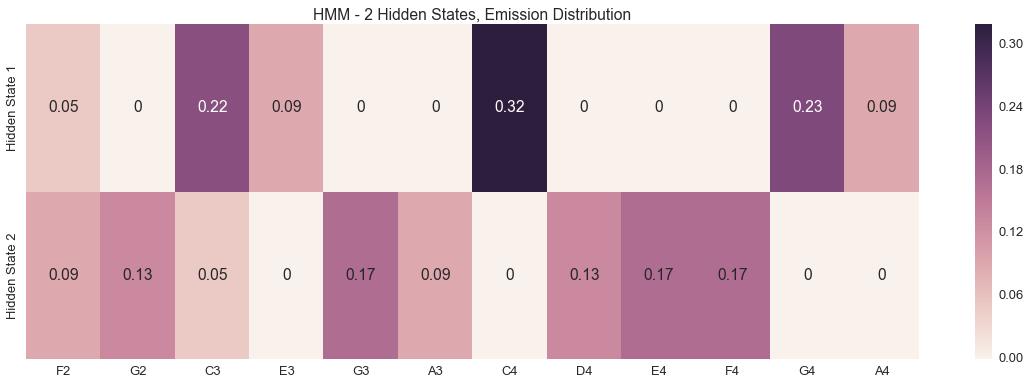

In [10]:
sns.set(font_scale=1.3)
print('Initial Distribution')
print(np.round(pi2, 2))
plt.figure(figsize = (20,6))
plt.title('HMM - 2 Hidden States, Emission Distribution')
order2 = pd.DataFrame(np.round(phi2, 2))
order2.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
order2.index = ['Hidden State 1', 'Hidden State 2']
axs = sns.heatmap(order2, annot=True)

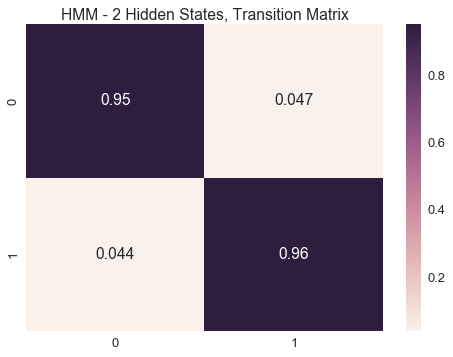

In [11]:
plt.title('HMM - 2 Hidden States, Transition Matrix')
axs = sns.heatmap(Tmat2, annot=True)

### 5 Hidden States

Initial Distribution
[ 0.  0.  0.  0.  1.]


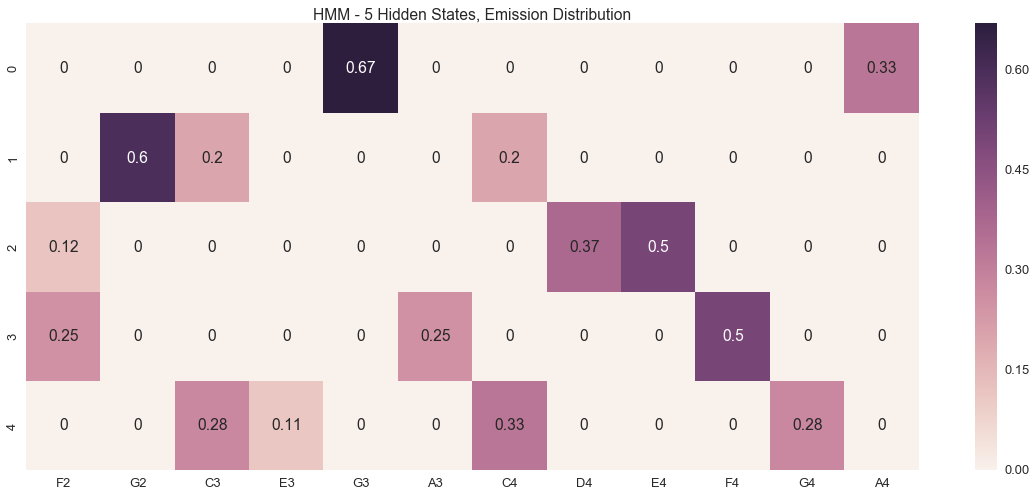

In [12]:
print('Initial Distribution')
print(np.round(pi5, 2))
plt.figure(figsize = (20,8))
plt.title('HMM - 5 Hidden States, Emission Distribution')
order5 = pd.DataFrame(np.round(phi5,2))
order5.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
#order5.index = ['Hidden State 1', 'Hidden State 2', 'Hidden State 3', 'Hidden State 4', 'Hidden State 5']
axs = sns.heatmap(order5, annot=True)

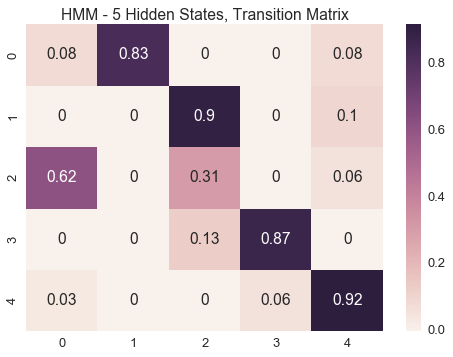

In [13]:
plt.title('HMM - 5 Hidden States, Transition Matrix')
axs = sns.heatmap(np.round(Tmat5, 2), annot=True)

### 10 Hidden States

Initial Distribution
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


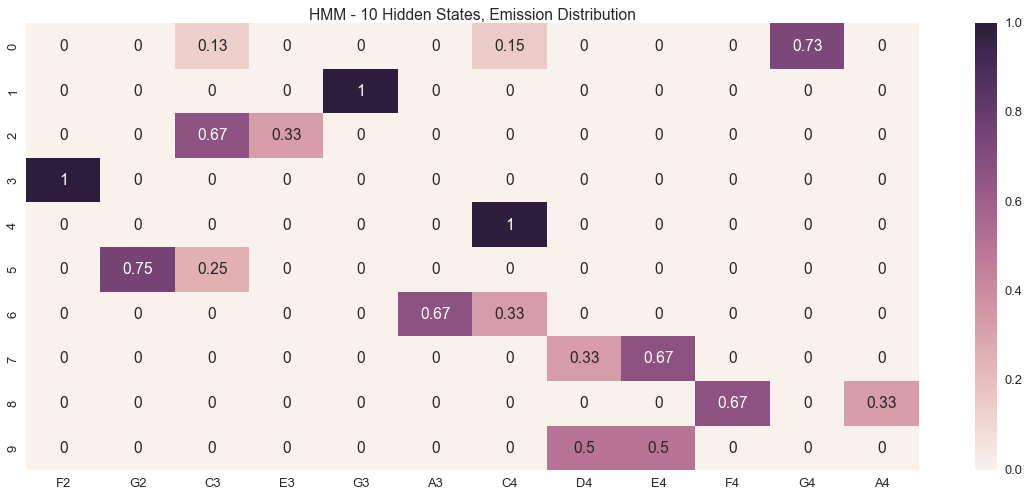

In [14]:
print('Initial Distribution')
print(np.round(pi10, 2))
plt.figure(figsize = (20,8))
plt.title('HMM - 10 Hidden States, Emission Distribution')
order10 = pd.DataFrame(np.round(phi10,2))
order10.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
#order5.index = ['Hidden State 1', 'Hidden State 2', 'Hidden State 3', 'Hidden State 4', 'Hidden State 5']
axs = sns.heatmap(order10, annot=True)

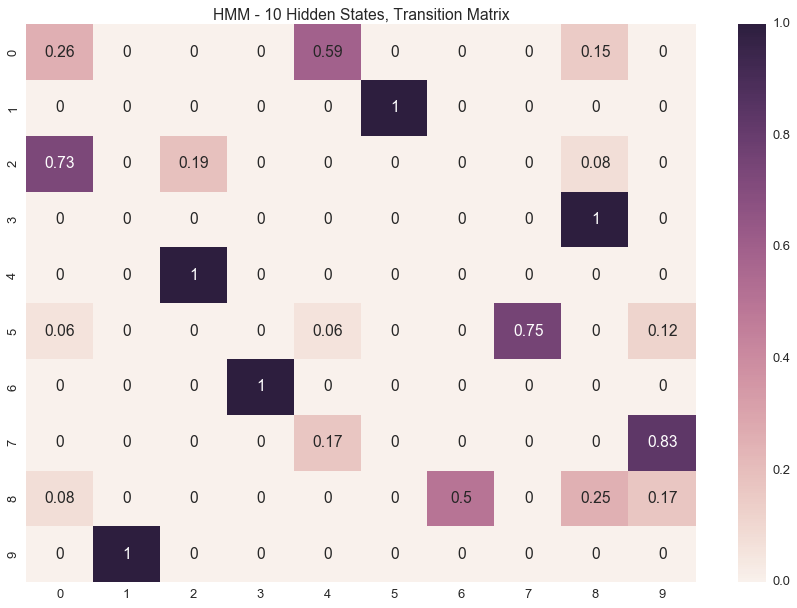

In [15]:
plt.figure(figsize = (15,10))
plt.title('HMM - 10 Hidden States, Transition Matrix')
axs = sns.heatmap(np.round(Tmat10,2), annot=True)

### 15 Hidden States

Initial Distribution
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


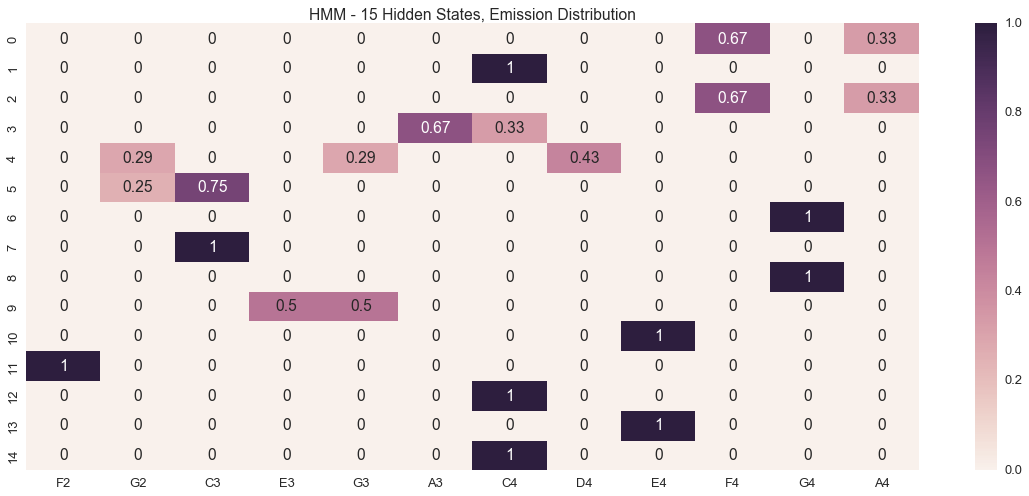

In [16]:
print('Initial Distribution')
print(np.round(pi15, 2))
plt.figure(figsize = (20,8))
plt.title('HMM - 15 Hidden States, Emission Distribution')
order15 = pd.DataFrame(np.round(phi15, 2))
order15.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
#order5.index = ['Hidden State 1', 'Hidden State 2', 'Hidden State 3', 'Hidden State 4', 'Hidden State 5']
axs = sns.heatmap(order15, annot=True)

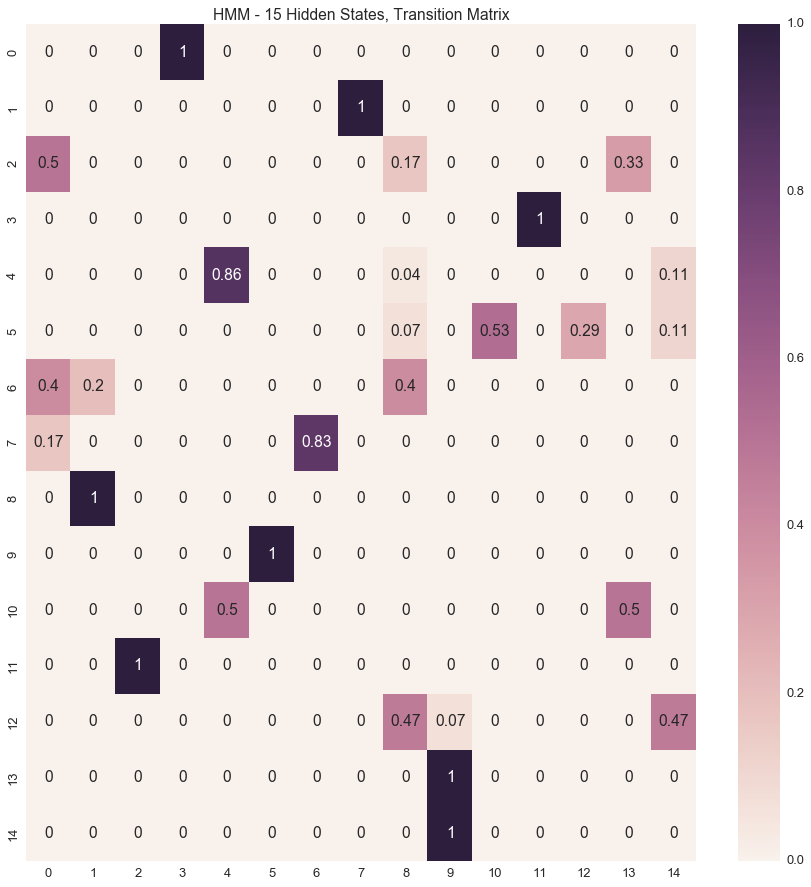

In [17]:
plt.figure(figsize = (15,15))
plt.title('HMM - 15 Hidden States, Transition Matrix')
axs = sns.heatmap(np.round(Tmat15, 2), annot=True)

### 20 Hidden States

Initial Distribution
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.]


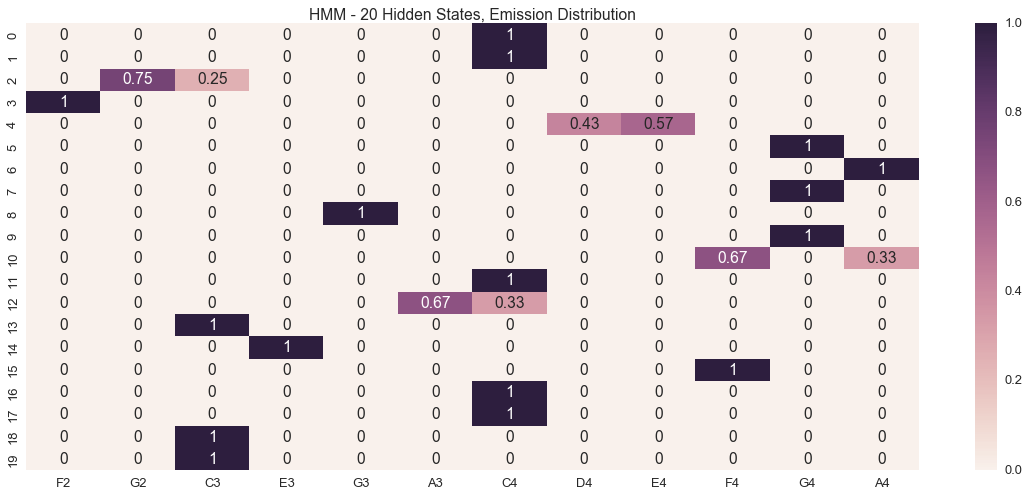

In [18]:
print('Initial Distribution')
print(np.round(pi20, 2))
plt.figure(figsize = (20,8))
plt.title('HMM - 20 Hidden States, Emission Distribution')
order20 = pd.DataFrame(np.round(phi20, 2))
order20.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
#order5.index = ['Hidden State 1', 'Hidden State 2', 'Hidden State 3', 'Hidden State 4', 'Hidden State 5']
axs = sns.heatmap(order20, annot=True)

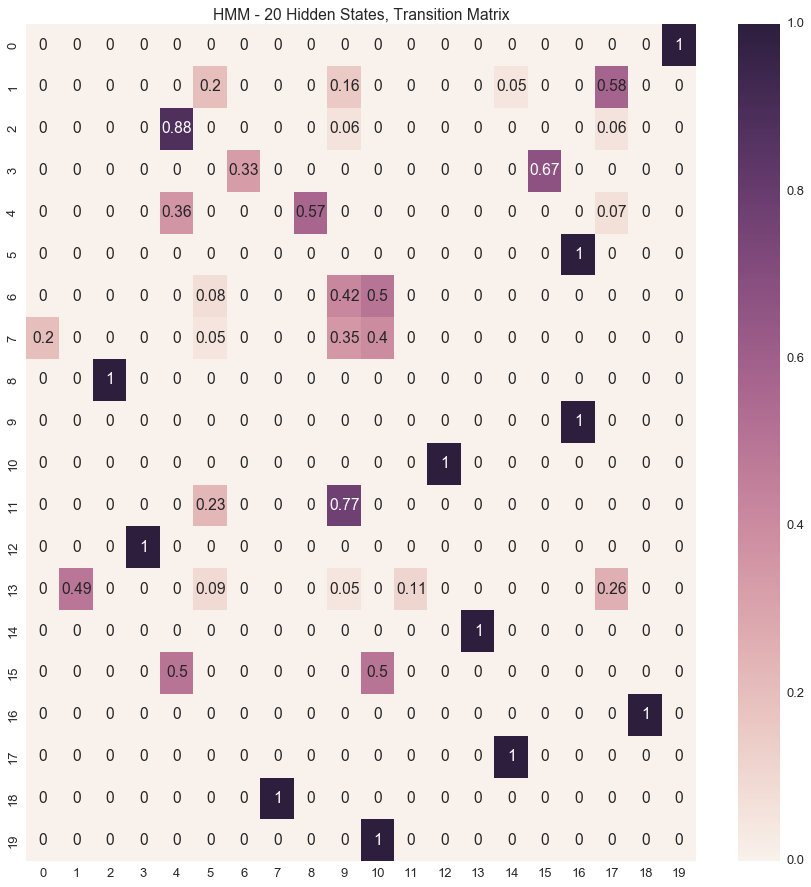

In [19]:
plt.figure(figsize = (15,15))
plt.title('HMM - 20 Hidden States, Transition Matrix')
axs = sns.heatmap(np.round(Tmat20, 2), annot=True)

### 25 Hidden States

Initial Distribution
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


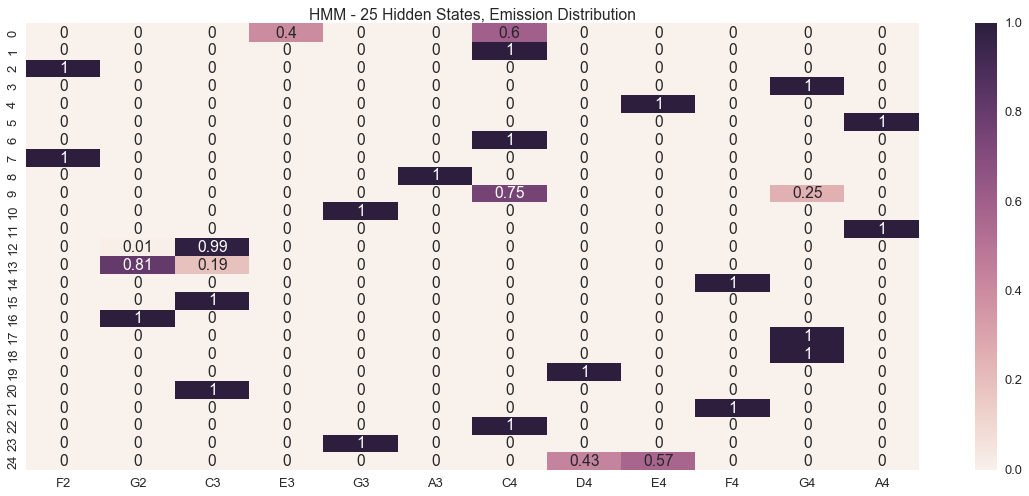

In [20]:
print('Initial Distribution')
print(np.round(pi25, 2))
plt.figure(figsize = (20,8))
plt.title('HMM - 25 Hidden States, Emission Distribution')
order25 = pd.DataFrame(np.round(phi25, 2))
order25.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
#order5.index = ['Hidden State 1', 'Hidden State 2', 'Hidden State 3', 'Hidden State 4', 'Hidden State 5']
axs = sns.heatmap(order25, annot=True)

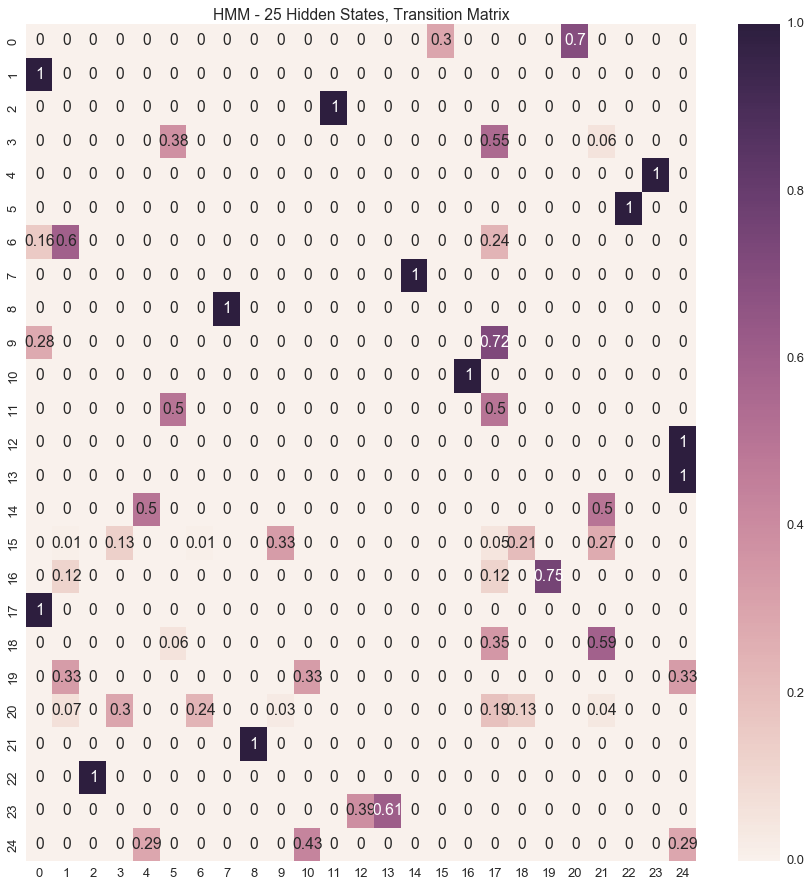

In [21]:
plt.figure(figsize = (15,15))
plt.title('HMM - 25 Hidden States, Transition Matrix')
axs = sns.heatmap(np.round(Tmat25, 2), annot=True)

## Compare Models
Focus on emission distributions.

### Random HMM

In [22]:
_, old5, new5_rand, z5_rand, pi5_rand, phi5_rand, Tmat5_rand = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'random', 5, 10E-7, 1000, None, metrics_calc = True, case_study = True)
print('5 done')

metrics/twinkle-twinkle-little-star__random_5-tol1e-06.csv
5 done


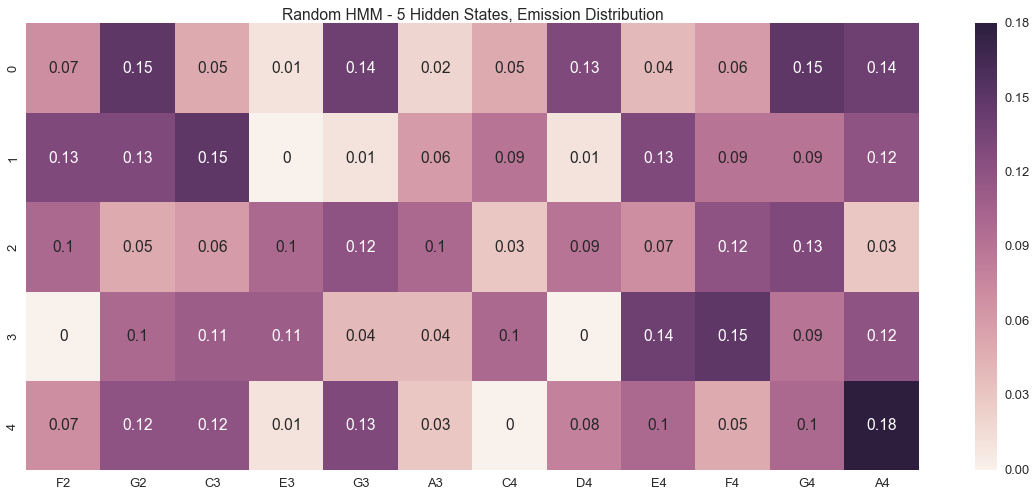

In [23]:
plt.figure(figsize = (20,8))
plt.title('Random HMM - 5 Hidden States, Emission Distribution')
order5_rand = pd.DataFrame(np.round(phi5_rand, 2))
order5_rand.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_rand, annot=True)

### LR-HMM

metrics/twinkle-twinkle-little-star__first_order-LR_5-tol1e-06.csv


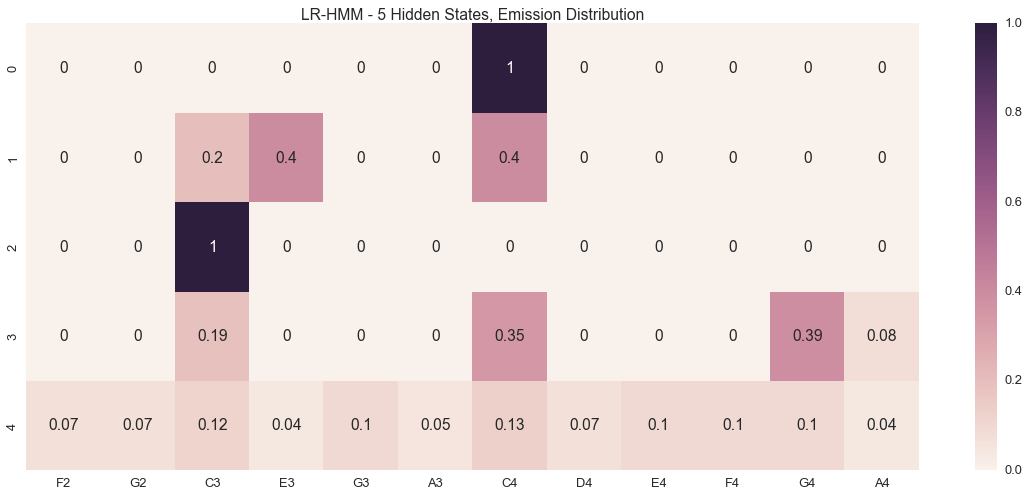

In [25]:
_, old5, new5_1LR, z5_1LR, pi5_LR, phi5_1LR, Tmat5_1LR = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'first_order-LR', 5, 10E-7, 1000, None, metrics_calc = True, 
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('LR-HMM - 5 Hidden States, Emission Distribution')
order5_1LR = pd.DataFrame(np.round(phi5_1LR, 2))
order5_1LR.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_1LR, annot=True)

### 2-HMM

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
metrics/twinkle-twinkle-little-star__second_order_5-tol1e-06.csv


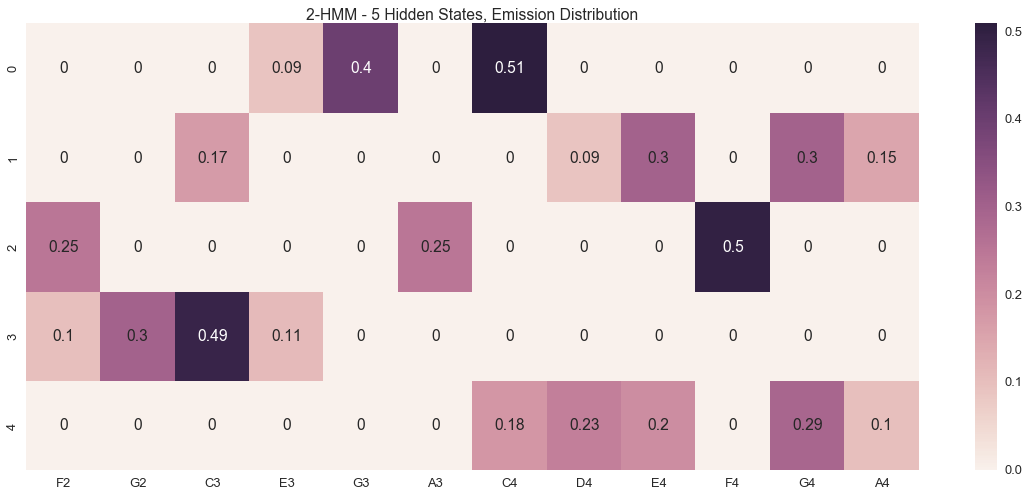

In [26]:
_, old5, new5_2, z5_2, pi52, phi5_2, Tmat5_2 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'second_order', 5, 10E-7, 1000, None, metrics_calc = True, 
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('2-HMM - 5 Hidden States, Emission Distribution')
order5_2 = pd.DataFrame(np.round(phi5_2, 2))
order5_2.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_2, annot=True)

### 2LR-HMM

0
1
2
3
4
5
6
7
metrics/twinkle-twinkle-little-star__second_order-LR_5-tol1e-06.csv


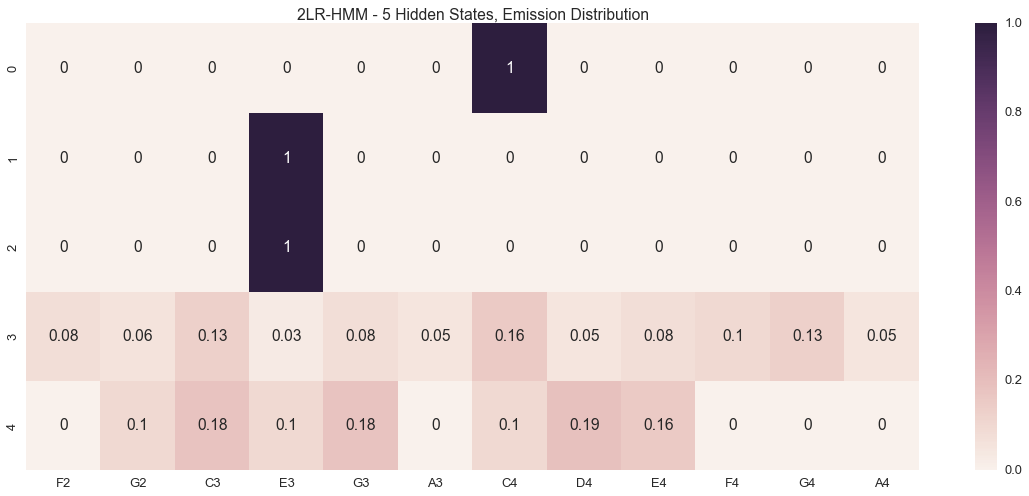

In [27]:
_, old5, new5_2LR, z5_2LR, pi5_2LR, phi5_2LR, Tmat5_2LR = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'second_order-LR', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('2LR-HMM - 5 Hidden States, Emission Distribution')
order5_2LR = pd.DataFrame(np.round(phi5_2LR, 2))
order5_2LR.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_2LR, annot=True)

### 3-HMM

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
0
1
2
metrics/twinkle-twinkle-little-star__third_order_5-tol1e-06.csv


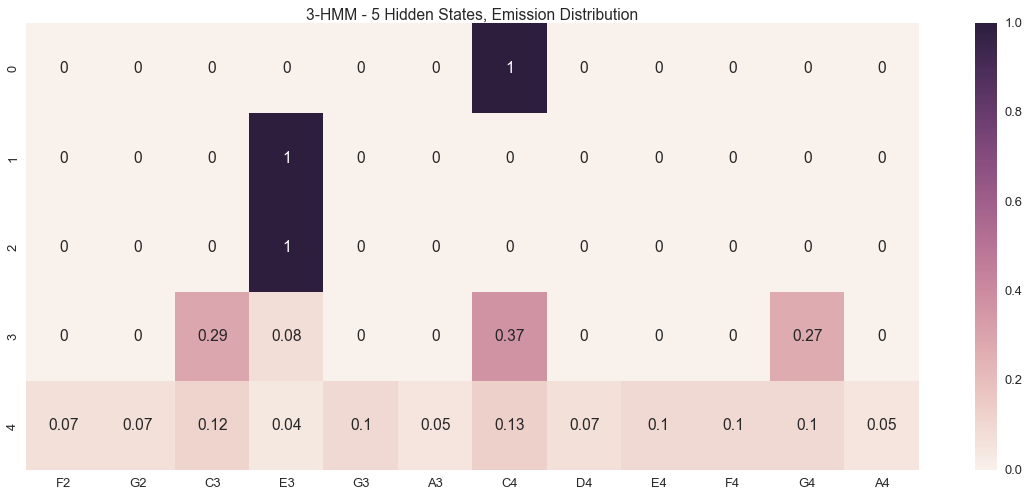

In [28]:
_, old5, new5_3, z5_3, pi5_3, phi5_3, Tmat5_3 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'third_order', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('3-HMM - 5 Hidden States, Emission Distribution')
order5_3 = pd.DataFrame(np.round(phi5_3, 2))
order5_3.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_3, annot=True)

### 3LR-HMM

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
metrics/twinkle-twinkle-little-star__third_order-LR_5-tol1e-06.csv


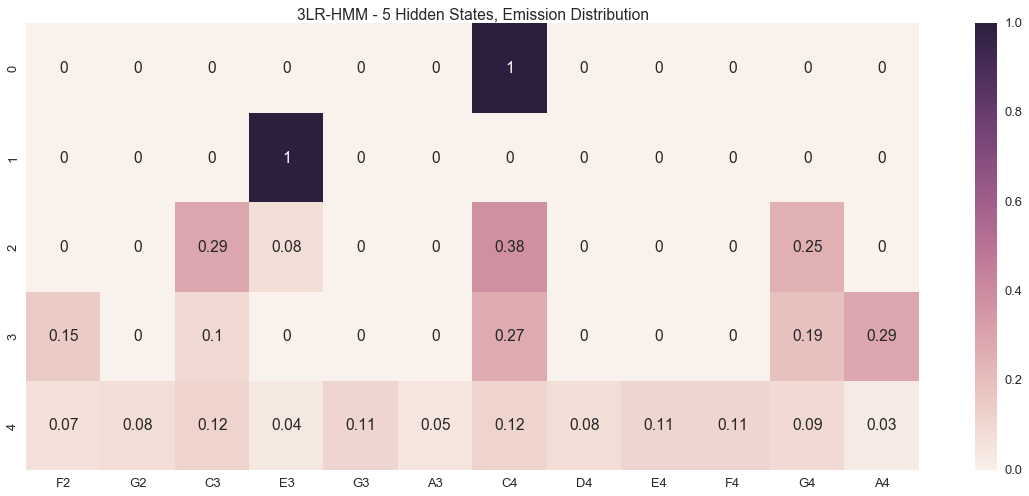

In [30]:
_, old5, new5_3LR, z5_3LR, pi5_3LR, phi5_3LR, Tmat5_3LR = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'third_order-LR', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('3LR-HMM - 5 Hidden States, Emission Distribution')
order5_3LR = pd.DataFrame(np.round(phi5_3LR, 2))
order5_3LR.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_3LR, annot=True)

### TSHMM 5-2

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
metrics/twinkle-twinkle-little-star__TSHMM_5-tol1e-06.csv


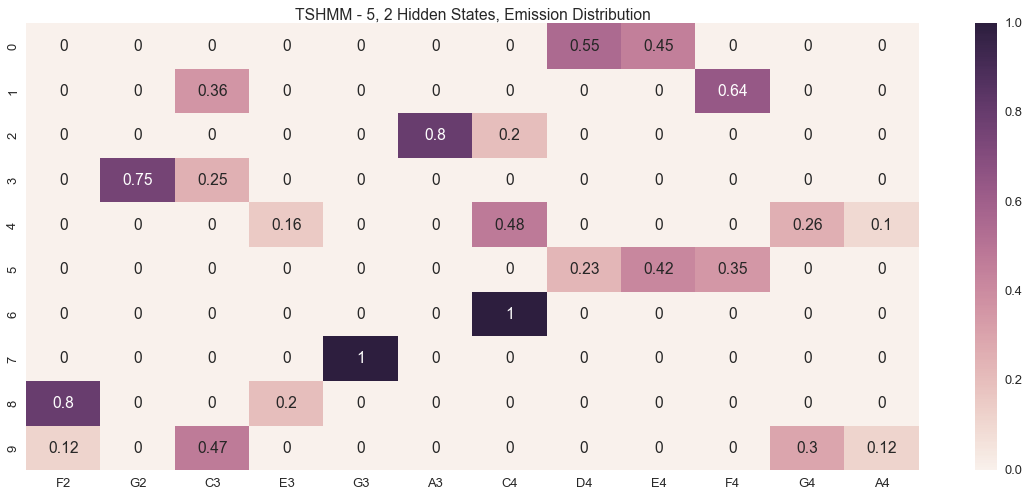

In [31]:
_, old5, new5_2h1, z5_2h1, pi5_2h1, phi5_2h1, Tmat5_2h1 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'TSHMM', 5, 10E-7, 1000, 2, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('TSHMM - 5, 2 Hidden States, Emission Distribution')
order5_2h1 = pd.DataFrame(np.round(phi5_2h1, 2))
order5_2h1.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_2h1, annot=True)

### TSHMM 2-5

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
metrics/twinkle-twinkle-little-star__TSHMM_2-tol1e-06.csv


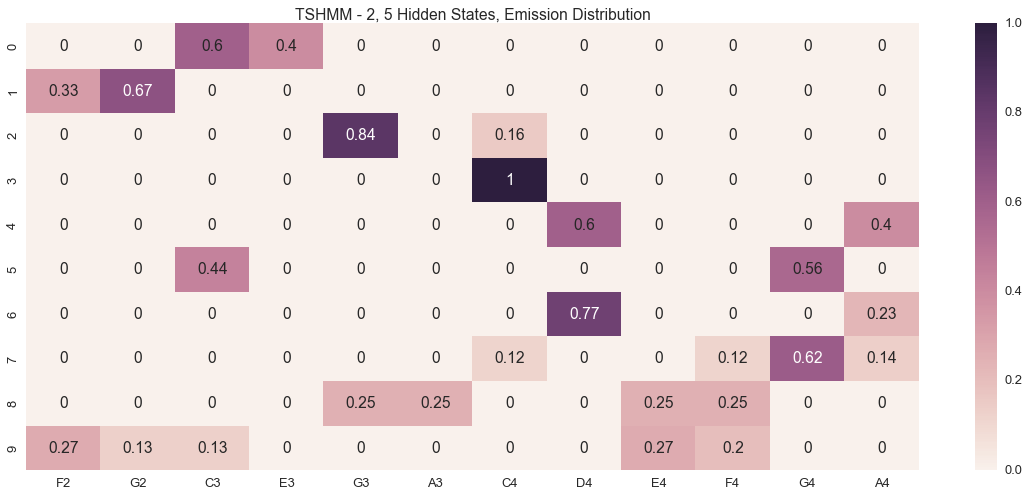

In [32]:
_, old5, new5_2h2, z5_2h2, pi5_2h2, phi5_2h2, Tmat5_2h2 = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'TSHMM', 2, 10E-7, 1000, 5, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('TSHMM - 2, 5 Hidden States, Emission Distribution')
order5_2h2 = pd.DataFrame(np.round(phi5_2h2, 2))
order5_2h2.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_2h2, annot=True)

### HSMM

1
2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


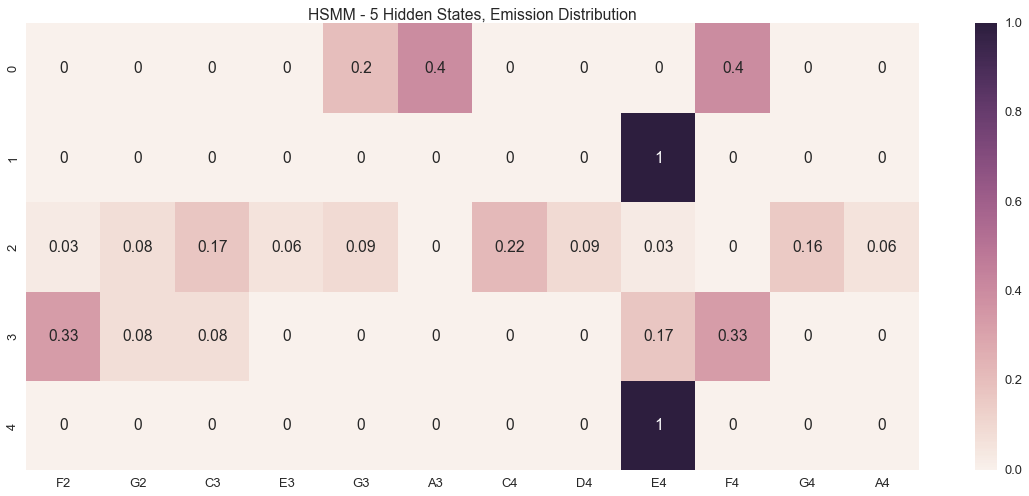

In [33]:
_, old5, new5_hsmm, z5_hsmm, pi5_hsmm, phi5_hsmm, Tmat5_hsmm = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'HSMM', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('HSMM - 5 Hidden States, Emission Distribution')
order5_hsmm = pd.DataFrame(np.round(phi5_hsmm, 2))
order5_hsmm.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_hsmm, annot=True)

### ARHMM

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
1
metrics/twinkle-twinkle-little-star__ARHMM_5-tol1e-06.csv


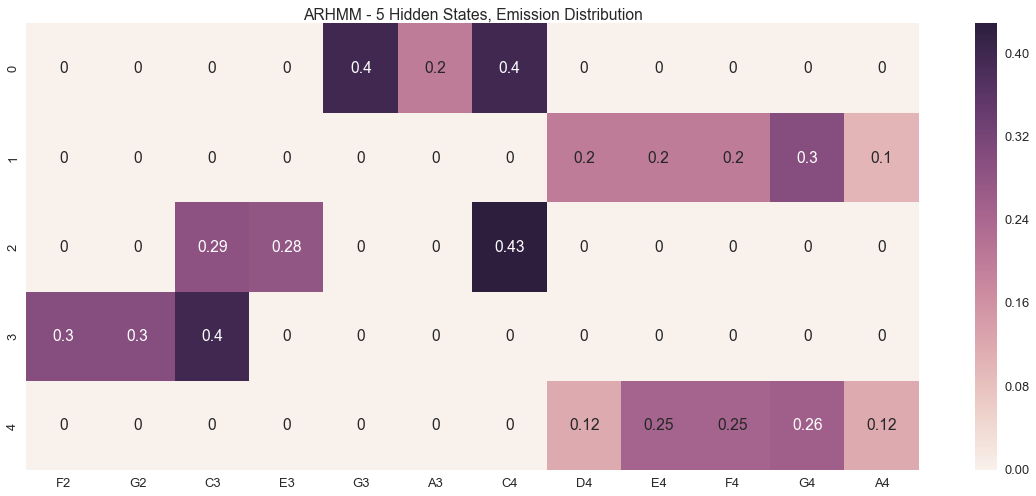

In [34]:
_, old5, new5_ar, z5_ar, pi5_ar, phi5_ar, Tmat5_ar = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'ARHMM', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('ARHMM - 5 Hidden States, Emission Distribution')
order5_ar = pd.DataFrame(np.round(phi5_ar, 2))
order5_ar.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_ar, annot=True)

### Factorial

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
metrics/twinkle-twinkle-little-star__factorial_5-tol1e-06.csv

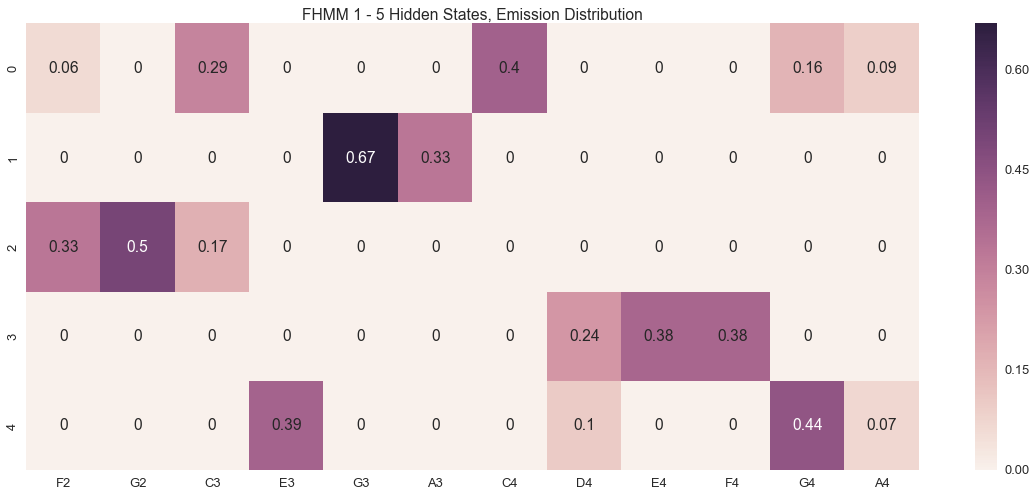

In [35]:
_, old5, new5_fac, z5_fac, pi5_fac, phi5_fac, Tmat5_fac = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'factorial', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('FHMM 1 - 5 Hidden States, Emission Distribution')
order5_fac0 = pd.DataFrame(np.round(phi5_fac[0], 2))
order5_fac0.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_fac0, annot=True)

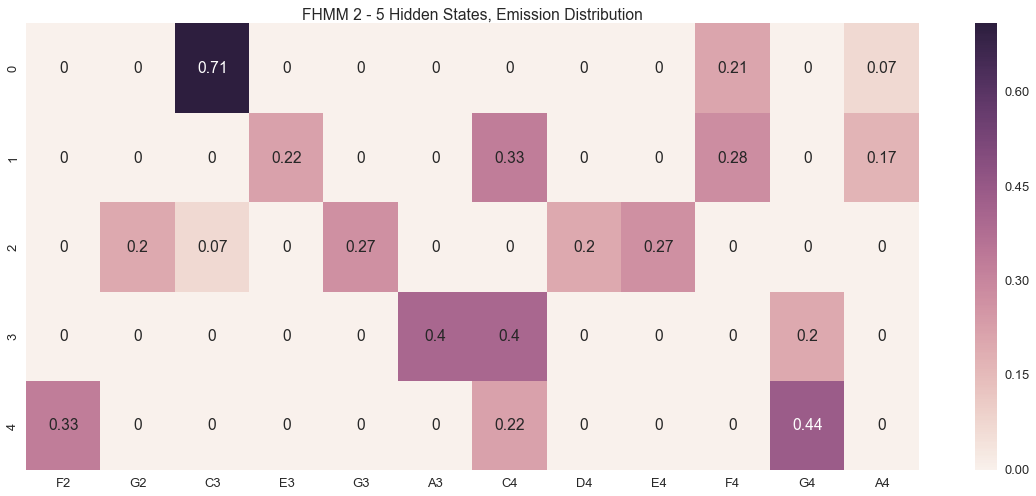

In [36]:
plt.figure(figsize = (20,8))
plt.title('FHMM 2 - 5 Hidden States, Emission Distribution')
order5_fac1 = pd.DataFrame(np.round(phi5_fac[1], 2))
order5_fac1.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_fac1, annot=True)

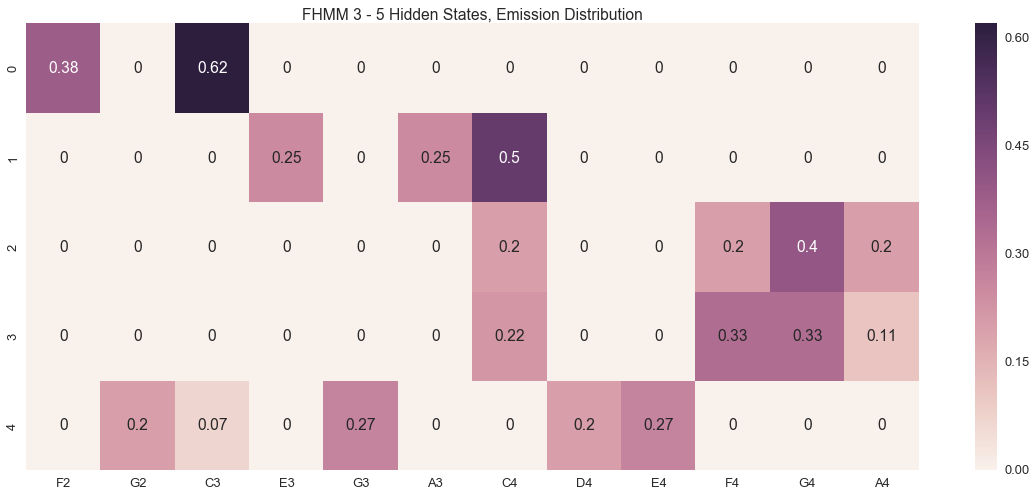

In [37]:
plt.figure(figsize = (20,8))
plt.title('FHMM 3 - 5 Hidden States, Emission Distribution')
order5_fac2 = pd.DataFrame(np.round(phi5_fac[2], 2))
order5_fac2.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_fac2, annot=True)

### Layered

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
metrics/twinkle-twinkle-little-star__layered_5-tol1e-06.csv


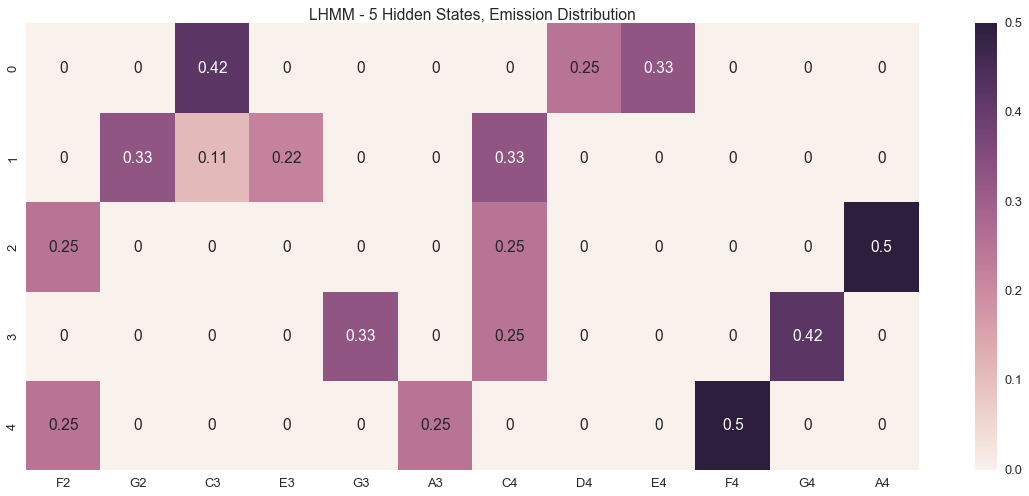

In [38]:
_, old5, new5_lay, z5_lay, pi5_lay, phi5_lay, Tmat5_lay = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'layered', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

plt.figure(figsize = (20,8))
plt.title('LHMM - 5 Hidden States, Emission Distribution')
order5_lay = pd.DataFrame(np.round(phi5_lay[0], 2))
order5_lay.columns = ['F2', 'G2', 'C3', 'E3', 'G3', 'A3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4']
axs = sns.heatmap(order5_lay, annot=True)

### TVAR

In [41]:
_, old5, new5_tvar, z5_tvar, pi5_tvar, phi5_tvar, Tmat5_tvar = hmm_compose('OriginalCSV/twinkle-twinkle-little-star-orig.csv', 
                                                   'NewCSV/twinkle-twinkle-little-star.csv', 256, 
                                                   'TVAR', 5, 10E-7, 1000, None, metrics_calc = True,
                                                                    case_study = True)

7
(7, 180, 1000)
metrics/twinkle-twinkle-little-star__TVAR_7-tol1e-06.csv


## Case Study - Metrics

In [42]:
## Function to process metrics and calculate RMSE
## Input: filename = filename where metrics values for piece of interested is saved
## Output:
##        metrics = original metrics as a dataframe, no computation
##        rmse = RMSE value for every column of metrics, pandas dataframe
##        hints = counts of harmonic intervals
##        mints = counts of melodic intervals
##        perc = array of percentage of perfect harmonic intervals, percentage of imperfect consonant harmonic intervals
##               percentage of dissonant harmonic intervals, percentage of perfect melodic intervals, 
##               percentage of imperfect consonant melodic intervals, percentage of dissonant melodic intervals
##        note_count = normalized note count of each note in the original piece
##        acf = acf values out to lag-40
##        pacf = pacf values out to lag-40
##        print_metrics = pandas dataframe formatted to display the average empirical entropy of all generated pieces,
##               the mutual information and edit distance between the original and generated pieces, averaged across all
##               generated pieces, the RMSE for hints averaged across all 12 intervals, the RMSE for mints averaged
##               across all 12 intervals, the average RMSE of per, the average RMSE of the note counts averaged across
##               all unique notes in the original piece, the average ACF RMSE averaged across all 40 lags and the average
##               PACF averaged across all 40 lags

def process_metrics(filename):
    metrics = pd.read_csv(filename, header = None)
    rmse = np.sqrt(((metrics - metrics.loc[0,:])**2).sum(axis = 0)/metrics.shape[0])  #calculate RMSE
    print_metrics = pd.DataFrame(columns = ['entropy', 'mutual_info', 'edit', 'h_ints', 'm_ints',
                                           'percent', 'note_counts', 'acf', 'pacf'])

    hints = metrics.loc[:, 3:15]
    mints = metrics.loc[:, 15:27]
    perc = metrics.loc[:, 27:33]
    note_count = metrics.loc[:, 33:metrics.shape[1]-2*41]
    acf = metrics.loc[:, metrics.shape[1]-2*41:]
    pacf = metrics.loc[:, metrics.shape[1]-41:]
    print_metrics.loc[0] = [np.mean(metrics.iloc[1:, 0]), np.mean(metrics.iloc[1:, 1]), np.mean(metrics.iloc[1:, 2]), 
                            np.mean(rmse[3:15]), np.mean(rmse[15:27]),
                              np.mean(rmse[27:33]), np.mean(rmse[33:metrics.shape[1]-2*41]),
                              np.mean(rmse[metrics.shape[1]-2*41:]), np.mean(rmse[metrics.shape[1]-41:])]

    print(metrics.shape)
    return(metrics, rmse, hints, mints, perc, note_count, acf, pacf, print_metrics)

## Original "Twinkle, Twinkle, Little Star" Metrics

In [45]:
m1, rmse1, _, _, _, _, acf1, pacf1, df1 = process_metrics('metrics/twinkle-twinkle__first_order_5-tol1e-06-metrics.csv')
print('Entropy:', m1.iloc[0,0])
print('Harmonic Intervals:', m1.iloc[0, 3:15])
print('Melodic Intervals:', m1.iloc[0, 15:27])
print('Percent Intervals:', m1.iloc[0, 27:33])
print('Note Counts:', m1.iloc[0, 33:m1.shape[1]-2*41-1])
print('Average ACF/PACF:', np.mean(m1.iloc[0, m1.shape[1]-2*41:]), np.mean(m1.iloc[0, m1.shape[1]-41:]))

(1001, 127)
Entropy: 2.40441708009
Harmonic Intervals: 3     20.0
4      4.0
5     20.0
6      7.0
7     15.0
8     10.0
9      0.0
10    34.0
11    12.0
12    10.0
13     0.0
14     0.0
Name: 0, dtype: float64
Melodic Intervals: 15    47.0
16     8.0
17    40.0
18    20.0
19    26.0
20    24.0
21     0.0
22    46.0
23    18.0
24    36.0
25    22.0
26     8.0
Name: 0, dtype: float64
Percent Intervals: 27    0.484848
28    0.333333
29    0.181818
30    0.396610
31    0.338983
32    0.264407
Name: 0, dtype: float64
Note Counts: 33    0.066667
34    0.066667
35    0.133333
36    0.044444
37    0.088889
38    0.044444
39    0.155556
40    0.066667
41    0.088889
42    0.088889
43    0.111111
Name: 0, dtype: float64
Average ACF/PACF: -0.0004080434473085546 -0.00987005190485703


In [46]:
m1_LR, rmse1_LR, _, _, _, _, acf1_LR, pacf1_LR, df1_LR = process_metrics('metrics/twinkle-twinkle__first_order-LR_5-tol1e-06-metrics.csv')
m2, rmse2, _, _, _, _, acf2, pacf2, df2 = process_metrics('metrics/twinkle-twinkle__second_order_5-tol1e-06-metrics.csv')
m2_LR, rmse2_LR, _, _, _, _, acf2_LR, pacf2_LR, df2_LR = process_metrics('metrics/twinkle-twinkle__second_order-LR_5-tol1e-06-metrics.csv')
m3, rmse3, _, _, _, _, acf3, pacf3, df3 = process_metrics('metrics/twinkle-twinkle__third_order_5-tol1e-06-metrics.csv')
m3_LR, rmse3_LR, _, _, _, _, acf3_LR, pacf3_LR, df3_LR = process_metrics('metrics/twinkle-twinkle__third_order-LR_5-tol1e-06-metrics.csv')
mr, rmser, _, _, _, _, acfr, pacfr, dfr = process_metrics('metrics/twinkle-twinkle__random_5-tol1e-06-metrics.csv')
m_hsmm, rmse_hsmm, _, _, _, _, acf_hsmm, pacf_hsmm, df_hsmm = process_metrics('metrics/twinkle-twinkle__HSMM_5-tol1e-06-metrics.csv')
m_arhmm, rmse_arhmm, _, _, _, _, acf_arhmm, pacf_arhmm, df_arhmm = process_metrics('metrics/twinkle-twinkle__ARHMM_5-tol1e-06-metrics.csv')
m_2h5, rmse_2h5, _, _, _, _, acf_2h5, pacf_2h5, df_2h5 = process_metrics('metrics/twinkle-twinkle-little-star__two_hidden_states_5-tol1e-06.csv')
m_2h2, rmse_2h2, _, _, _, _, acf_2h2, pacf_2h2, df_2h2 = process_metrics('metrics/twinkle-twinkle-little-star__two_hidden_states_2-tol1e-06.csv')
m_fac, rmse_fac, _, _, _, _, acf_fac, pacf_fac, df_fac = process_metrics('metrics/twinkle-twinkle__factorial_5-tol1e-06-metrics.csv')
m_lay, rmse_lay, _, _, _, _, acf_lay, pacf_lay, df_lay = process_metrics('metrics/twinkle-twinkle__layered_5-tol1e-06-metrics.csv')
m_tvar, rmse_tvar, _, _, _, _, acf_tvar, pacf_tvar, df_tvar = process_metrics('metrics/twinkle-twinkle__TVAR_7-tol1e-06-metrics.csv')

metrics_df = pd.concat([df1, df1_LR, df2, df2_LR, df3, df3_LR, dfr, df_hsmm, df_arhmm, df_2h5, df_2h2, df_fac, df_lay, df_tvar])
metrics_df.index = ['First Order', 'First Order LR', 'Second Order', 'Second Order LR', 'Third Order',
                   'Third Order LR', 'Random', 'HSMM', 'ARHMM', "Two Hidden States 5-2", "Two Hidden States 2-5", 'Factorial', 'Layered', 'TVAR']
metrics_df.round(3)

(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)
(1001, 127)


,entropy,mutual_info,edit,h_ints,m_ints,percent,note_counts,acf,pacf
First Order,2.315,0.400,0.742,11.360,11.738,0.091,0.033,0.244,0.222
First Order LR,2.371,0.386,0.765,11.673,12.662,0.098,0.022,0.245,0.223
Second Order,2.339,0.383,0.777,12.578,13.358,0.096,0.026,0.245,0.222
Second Order LR,2.384,0.382,0.780,12.594,13.905,0.101,0.024,0.245,0.223
Third Order,2.397,0.386,0.780,12.448,13.662,0.100,0.021,0.246,0.223
Third Order LR,2.377,0.380,0.784,12.616,13.504,0.098,0.023,0.246,0.223
Random,2.426,0.389,0.812,13.024,13.947,0.103,0.040,0.246,0.224
HSMM,2.324,0.386,0.767,11.740,12.600,0.095,0.030,0.246,0.223
ARHMM,2.374,0.382,0.786,12.565,13.560,0.098,0.020,0.245,0.223
Two Hidden States 5-2,1.896,0.284,0.773,9.224,9.807,0.118,0.075,0.225,0.211


# Bach Validation

In [49]:
_, old5_b, new5_b, z5_b, pi5_b, phi5_b, Tmat5_b = hmm_compose('OriginalCSV/book2-fugue07.csv', 
                                                   'NewCSV/book2-fugue07.csv', 64, 
                                                   'first_order', 5, 10E-7, 1, None, metrics_calc = False, 
                                                    case_study = True)
print('5 done')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


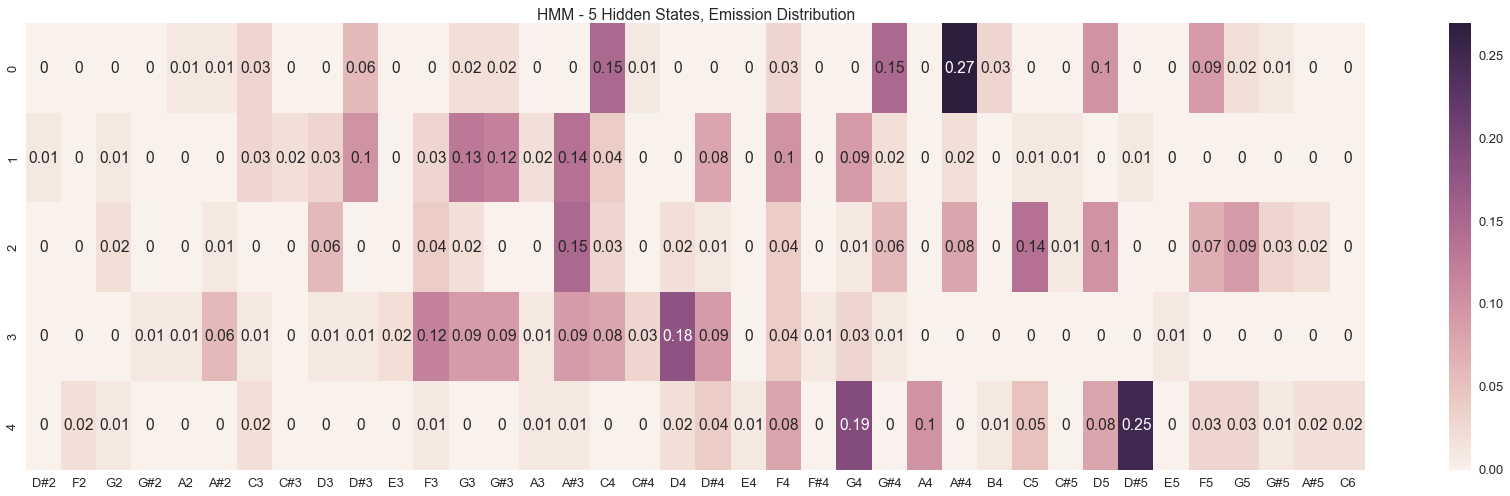

In [53]:
plt.figure(figsize = (30,8))
plt.title('HMM - 5 Hidden States, Emission Distribution')
order5_b = pd.DataFrame(np.round(phi5_b, 2))
order5_b.columns = ['D#2','F2','G2','G#2','A2','A#2','C3','C#3','D3','D#3','E3','F3','G3','G#3','A3','A#3','C4',
                    'C#4','D4','D#4','E4','F4','F#4','G4','G#4','A4','A#4','B4','C5','C#5','D5','D#5','E5', 
                    'F5' ,'G5','G#5','A#5','C6']   
axs = sns.heatmap(order5_b, annot=True)

# Listening Evaluation Results

In [111]:
model_list = ['first_order', 'second_order', 'third_order', 'first_order-LR', 'second_order-LR', 'third_order-LR',
             'ARHMM', 'HSMM', 'factorial', 'layered', 'random']
m_list = [25, 25, 10, 25, 25, 10, 25, 25, 25, 25, 25]
tol = 1E-5
it = 1000
count = 0
for model in model_list:
    m = m_list[count]
    print(model, m)
    hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, model, m, tol, it, None,
                metrics_calc = True, case_study = False)                      
    print('ode to joy done')
    hmm_compose('OriginalCSV/hark-the-herald-angels-sing.csv', 'NewCSV/hark-the-herald-angels-sing.csv', 128, model, m, tol, it, None,
                metrics_calc = True, case_study = False)                                       
    print('hark-the-hearald-angels-sing done')
    hmm_compose('OriginalCSV/we-three-kings-keyboard.csv', 'NewCSV/we-three-kings.csv', 64, model, m, tol, it, None,
                metrics_calc = True, case_study = False)                                       
    print('we three kings done')
    hmm_compose('OriginalCSV/moonlight-movement1.csv', 'NewCSV/moonlight-movement1.csv', 64, model, m, tol, it, None,
                metrics_calc = True, case_study = False)
    print('moonlight-movement1 done')
    hmm_compose('OriginalCSV/chopin-funeral-march.csv', 'NewCSV/chopin3.csv', 24, model, m, tol, it, None,
                metrics_calc = True, case_study = False)          
    print("funeral Done")
    hmm_compose('OriginalCSV/muss_1_format0.csv', 'NewCSV/muss_1_format0.csv', 240, model, m, tol, it, None,
                metrics_calc = True, case_study = False)    
    print('Pictures at an Exhibition')
    hmm_compose('OriginalCSV/Songwithoutwords06.csv', 'NewCSV/Songwithoutwords06.csv', 64, model, m, tol, it, None,
                metrics_calc = True, case_study = False)    
    print('Songs 6')
    hmm_compose('OriginalCSV/Songwithoutwords53.csv', 'NewCSV/Songwithoutwords53.csv', 64, model, m, tol, it, None,
                metrics_calc = True, case_study = False)    
    print('Songs 53')
    hmm_compose('OriginalCSV/ty_november_format0.csv', 'NewCSV/ty_november_format0.csv', 120, model, m, tol, it, None,
                metrics_calc = True, case_study = False)    
    print('Seasons')
    hmm_compose('OriginalCSV/lszt_hr2.csv', 'NewCSV/lszt_hr2.csv', 120, model, m, tol, it, None,
                metrics_calc = True, case_study = False)
    print('lszt_hr2 done')
    hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m, tol, it, None,
                metrics_calc = True, case_study = False)
    print('pachelbel done')
    count +=1

first_order 25
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
metrics/ode-to-joy__first_order_25-tol1e-05.csv
ode to joy done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
1

In [112]:
model = 'TSHMM'
m_list = [10, 5]
m2_list = [5, 10]
tol = 1E-5
it = 1000

count = 0
for m in m_list:
    m2 = m2_list[count]
    print(m, m2)
    hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, model, m, 
                tol, it, m2, metrics_calc = True, case_study = False)                      
    print('ode to joy done')
    hmm_compose('OriginalCSV/hark-the-herald-angels-sing.csv', 'NewCSV/hark-the-herald-angels-sing.csv', 128, 
                model, m, tol, it, m2,metrics_calc = True, case_study = False)                                       
    print('hark-the-hearald-angels-sing done')
    hmm_compose('OriginalCSV/we-three-kings-keyboard.csv', 'NewCSV/we-three-kings.csv', 64, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)                                       
    print('we three kings done')
    hmm_compose('OriginalCSV/moonlight-movement1.csv', 'NewCSV/moonlight-movement1.csv', 64, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)
    print('moonlight-movement1 done')
    hmm_compose('OriginalCSV/chopin-funeral-march.csv', 'NewCSV/chopin3.csv', 24, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)          
    print("funeral Done")
    hmm_compose('OriginalCSV/muss_1_format0.csv', 'NewCSV/muss_1_format0.csv', 240, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)    
    print('Pictures at an Exhibition')
    hmm_compose('OriginalCSV/Songwithoutwords06.csv', 'NewCSV/Songwithoutwords06.csv', 64, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)    
    print('Songs 6')
    hmm_compose('OriginalCSV/Songwithoutwords53.csv', 'NewCSV/Songwithoutwords53.csv', 64, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)    
    print('Songs 53')
    hmm_compose('OriginalCSV/ty_november_format0.csv', 'NewCSV/ty_november_format0.csv', 120, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)    
    print('Seasons')
    hmm_compose('OriginalCSV/lszt_hr2.csv', 'NewCSV/lszt_hr2.csv', 120, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)
    print('lszt_hr2 done')
    hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m, tol, it, m2,
                metrics_calc = True, case_study = False)
    print('pachelbel done')
    count +=1

10 5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
metrics/ode-to-joy__TSHMM_10-tol1e-05.csv
ode to joy done
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70


In [113]:
model = 'TVAR'
m = 25
tol = 1E-5
it = 1000

hmm_compose('OriginalCSV/beethoven-symphony9-4-ode-to-joy-piano-solo.csv', 'NewCSV/ode-to-joy.csv', 128, model, m, 
                tol, it, m2, metrics_calc = True, case_study = False)                      
print('ode to joy done')
hmm_compose('OriginalCSV/hark-the-herald-angels-sing.csv', 'NewCSV/hark-the-herald-angels-sing.csv', 128, 
            model, m, tol, it, m2,metrics_calc = True, case_study = False)                                       
print('hark-the-hearald-angels-sing done')
hmm_compose('OriginalCSV/we-three-kings-keyboard.csv', 'NewCSV/we-three-kings.csv', 64, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)                                       
print('we three kings done')
hmm_compose('OriginalCSV/moonlight-movement1.csv', 'NewCSV/moonlight-movement1.csv', 64, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)
print('moonlight-movement1 done')
hmm_compose('OriginalCSV/chopin-funeral-march.csv', 'NewCSV/chopin3.csv', 24, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)          
print("funeral Done")
hmm_compose('OriginalCSV/muss_1_format0.csv', 'NewCSV/muss_1_format0.csv', 240, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)    
print('Pictures at an Exhibition')
hmm_compose('OriginalCSV/Songwithoutwords06.csv', 'NewCSV/Songwithoutwords06.csv', 64, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)    
print('Songs 6')
hmm_compose('OriginalCSV/Songwithoutwords53.csv', 'NewCSV/Songwithoutwords53.csv', 64, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)    
print('Songs 53')
hmm_compose('OriginalCSV/ty_november_format0.csv', 'NewCSV/ty_november_format0.csv', 120, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)    
print('Seasons')
hmm_compose('OriginalCSV/lszt_hr2.csv', 'NewCSV/lszt_hr2.csv', 120, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)
print('lszt_hr2 done')
hmm_compose('OriginalCSV/pachelbel.csv', 'NewCSV/pachelbel.csv', 64, model, m, tol, it, m2,
            metrics_calc = True, case_study = False)
print('pachelbel done')

8
(8, 532, 1000)
metrics/ode-to-joy__TVAR_8-tol1e-05.csv
ode to joy done
9
(9, 1068, 1000)
metrics/hark-the-herald-angels-sing__TVAR_9-tol1e-05.csv
hark-the-hearald-angels-sing done
10
(10, 620, 1000)
metrics/we-three-kings__TVAR_10-tol1e-05.csv
we three kings done
11
(11, 432, 1000)
metrics/moonlight-movement1__TVAR_11-tol1e-05.csv
moonlight-movement1 done
10
(10, 588, 1000)
metrics/chopin3__TVAR_10-tol1e-05.csv
funeral Done
12
(12, 1343, 1000)
metrics/muss_1_format0__TVAR_12-tol1e-05.csv
Pictures at an Exhibition
7
(7, 582, 1000)
metrics/Songwithoutwords06__TVAR_7-tol1e-05.csv
Songs 6
10
(10, 955, 1000)
metrics/Songwithoutwords53__TVAR_10-tol1e-05.csv
Songs 53
7
(7, 290, 1000)
metrics/ty_november_format0__TVAR_7-tol1e-05.csv
Seasons
7
(7, 660, 1000)
metrics/lszt_hr2__TVAR_7-tol1e-05.csv
lszt_hr2 done
15
(15, 1050, 1000)
metrics/pachelbel__TVAR_15-tol1e-05.csv
pachelbel done
